In [3]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
data_path = "/home/haue/repositories/Masters/data/bananas/Al"
sim_path = "/home/haue/repositories/Masters/data/sims"
outputdir = "/figure_output/"

In [15]:
## Load in all files from the datapath with the suffix mlio.root
banana_files = glob.glob(os.path.join(data_path, "*mlio.root"))
simfile = glob.glob(os.path.join(sim_path, "*.txt"))
simfile


['/home/haue/repositories/Masters/data/sims/U1P1_simdata.txt']

In [16]:
#####
#Loading in of parameters needed for plotting and assigning them to lists
#These lists holds entries 0-3 which corresponds to detector id's 1-4
#####
Es = [[_] for _ in range(0,4)]
front_telescope_Es = [[_] for _ in range(0,4)]
back_telescope_Es = [[_] for _ in range(0,4)]
angles_of_incidence = [[_] for _ in range(0,4)]
Edeps = [[_] for _ in range(0,4)]
FIs = [[_] for _ in range(0,4)]
BIs = [[_] for _ in range (0,4)]

for f in banana_files:
    r = uproot.open(f)["a"]
    dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
    ids = ak.flatten(dum.id)
    es = ak.flatten(dum.E)
    fedeps = ak.flatten(dum.fEdep)
    bedeps = ak.flatten(dum.bEdep)
    thets = ak.flatten(dum.angle)
    Edeposits = ak.flatten(dum.Edep)
    bis = ak.flatten(dum.BI)
    fis = ak.flatten(dum.FI)
    for i in range(0, 4) :
        mask = (ids == i)
        Edeps[i].extend(Edeposits[mask])
        Es[i].extend(es[mask])
        angles_of_incidence[i].extend(thets[mask])
        front_telescope_Es[i].extend(fedeps[mask])
        back_telescope_Es[i].extend(bedeps[mask])
        FIs[i].extend(fis[mask])
        BIs[i].extend(bis[mask])
    #print("file ", f, " processed")
    if f==banana_files[-1]:
        print("Processing done!")

### Converting energies to MeV and angles to degrees
Edeps = [np.array(arr)/1e3 for arr in Edeps]
Es = [np.array(arr)/1e3 for arr in Es]
angles_of_incidence = [np.rad2deg(np.array(arr)) for arr in angles_of_incidence]
front_telescope_Es = [np.array(arr)/1e3 for arr in front_telescope_Es]
back_telescope_Es = [np.array(arr)/1e3 for arr in back_telescope_Es]

FIs = [np.array(arr) for arr in FIs]
BIs = [np.array(arr) for arr in BIs]

Processing done!


In [17]:
simdata = np.loadtxt(simfile[0], skiprows=9)
angle, Ep, fedep, bedep = zip(*simdata)
maxangle = np.max(angle)
mask = (angle == maxangle) & (np.array(fedep)>100) & (np.array(bedep)>100)
Ep = (np.array(Ep)[mask])/1e3
fedep = (np.array(fedep)[mask])/1e3
bedep = (np.array(bedep)[mask])/1e3


###
# Need to load in my banana cuts made on the graphs below so it can be visually seen what the cuts are.
###

cuts = "/home/haue/repositories/Masters/data/cuts/banana_cuts.root"
id0cut ="/home/haue/repositories/Masters/data/cuts/id0cuts.root" 
cutfile = uproot.open(cuts)
id0 = uproot.open(id0cut)

x1, y1 = id0["aboveregion"].values()
x2, y2 = id0["vertical1"].values()
x3, y3 = id0["vertical2"].values()
xs = [x1/1e3, x2/1e3, x3/1e3]
ys = [y1/1e3, y2/1e3, y3/1e3]

xU1, yU1 = cutfile["bananaU1"].values()
xU1 = xU1/1e3
yU1 = yU1/1e3


Text(0.5, 1.0, 'Histogram of Rounded Values')

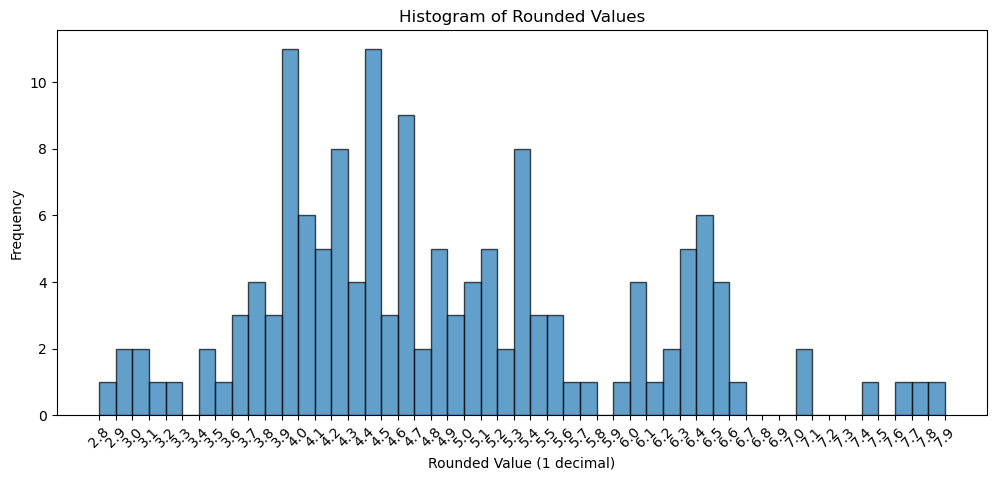

In [19]:
from matplotlib.path import Path
from collections import Counter

###
#Here i define the first polygon that is located above the banana. Then i make the cut that i only want the data points
#that resides within this polygon. Then i look for which energies are in this region and if some of them are similar
# the ones that are somewhat similar(rounded to first decimal) are grouped and counted and displayed in a histogram
###

polygon = np.column_stack((xs[0], ys[0]))
polygon_path = Path(polygon)
points = np.column_stack((back_telescope_Es[0], front_telescope_Es[0]))
mask = polygon_path.contains_points(points)
eB = back_telescope_Es[0][mask]
eF = front_telescope_Es[0][mask]
eS = Es[0][mask]

rounded_es = np.round(eS,1)

plt.figure(figsize=(12, 5))
plt.hist(rounded_es, bins=np.arange(min(rounded_es), max(rounded_es) + 0.1, 0.1), edgecolor="black", alpha=0.7)
plt.xticks(np.arange(min(rounded_es), max(rounded_es) + 0.1, 0.1), rotation=45)

# Labels
plt.xlabel("Rounded Value (1 decimal)")
plt.ylabel("Frequency")
plt.title("Histogram of Rounded Values")

[18, 12, 15, 10, 12, 11]

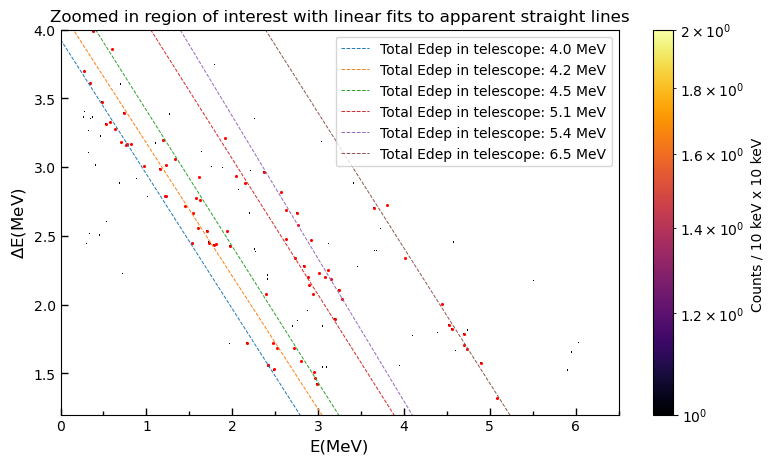

In [20]:
####################
#A closer look at the energies from this region and seeing if they somewhat follow a straight line.
from matplotlib.path import Path
def linfunc(x, a, b):
    return a*x+b

### Defining all the masked parameters for future use in the next couple windows.
polygon = np.column_stack((xs[0], ys[0]))
polygon_path = Path(polygon)
points = np.column_stack((back_telescope_Es[0], front_telescope_Es[0]))
mask = polygon_path.contains_points(points)
eb = back_telescope_Es[0][mask]
ef = front_telescope_Es[0][mask]
es = Es[0][mask]
fi = FIs[0][mask]
bi = BIs[0][mask]
###


plt.figure(figsize=(9,5))
plt.hist2d(eb, ef, bins=(np.arange(0, 10, 0.01), np.arange(0, 4, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

a_vals = []
b_vals = []
counts_online = []
## Intervals based on the previous histogram.
intervals_of_interest = [(3.9, 4.1), (4.1,4.31), (4.4,4.61), (5, 5.2), (5.3, 5.5), (6.4, 6.61)]
for i in intervals_of_interest:
    mask = (es>=i[0]) & (es<=i[1])
    ef_int = ef[mask]
    eb_int = eb[mask]
    plt.scatter(eb_int,ef_int, marker='o', s=1.5, color='r')
    popt, _ = sc.curve_fit(linfunc, eb_int, ef_int)
    a, b = popt
    a_vals.append(a)
    b_vals.append(b)
    counts_online.append(len(ef_int))
    ##Fitting to the data points that lies around a specific energy
    fit_x = np.linspace(0, 6, 100)
    fit_y = linfunc(fit_x, a, b)
    plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((i[0]+i[1])/2, 1)} MeV")





plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 6.5)
plt.ylim(1.2,4)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)


plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Zoomed in region of interest with linear fits to apparent straight lines")
counts_online

Text(0, 0.5, '$\\Delta$E(MeV)')

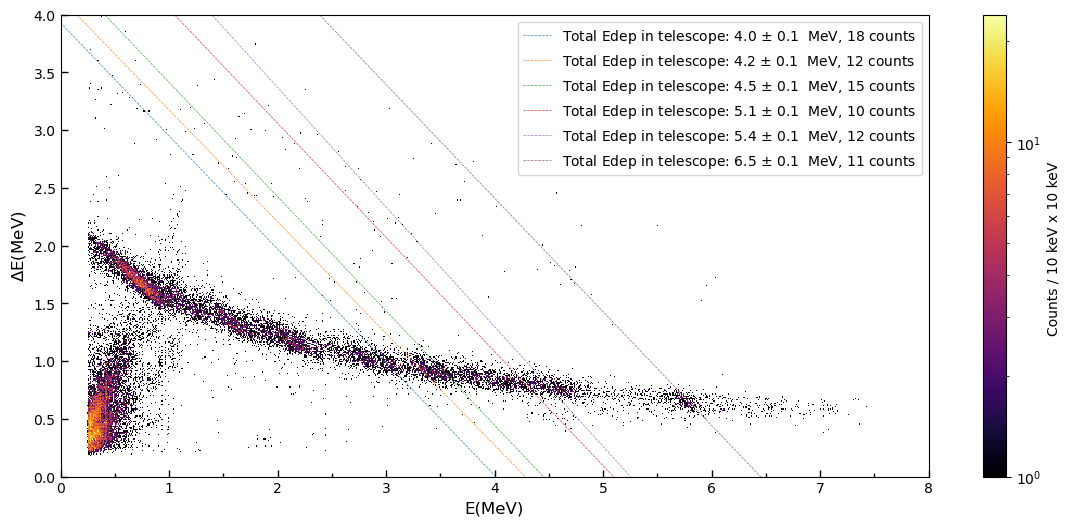

In [21]:
plt.figure(figsize=(14,6))
##Plotting entire banana spectrum
plt.hist2d(back_telescope_Es[0], front_telescope_Es[0], bins=(np.arange(0, 10, 0.01), np.arange(0, 4, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

##Plotting the lines based on the fits made in the last box
for a,b, i, j in zip(a_vals, b_vals, intervals_of_interest,range(len(intervals_of_interest))):
    fit_x = np.linspace(0, 7, 100)
    fit_y = linfunc(fit_x, a, b)
    plt.plot(fit_x,fit_y, ls='--', lw=0.5, alpha=0.9,
             label=rf"Total Edep in telescope: {np.round((i[0]+i[1])/2, 1)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV, {counts_online[j]} counts")

plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 8)
plt.ylim(0,4)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)

plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)


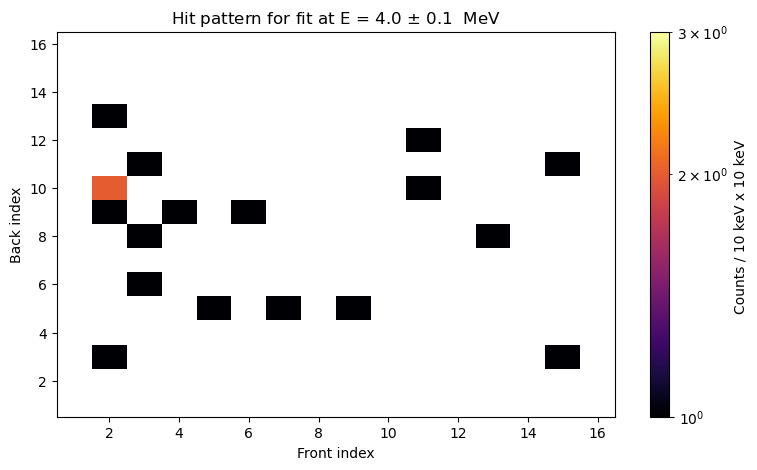

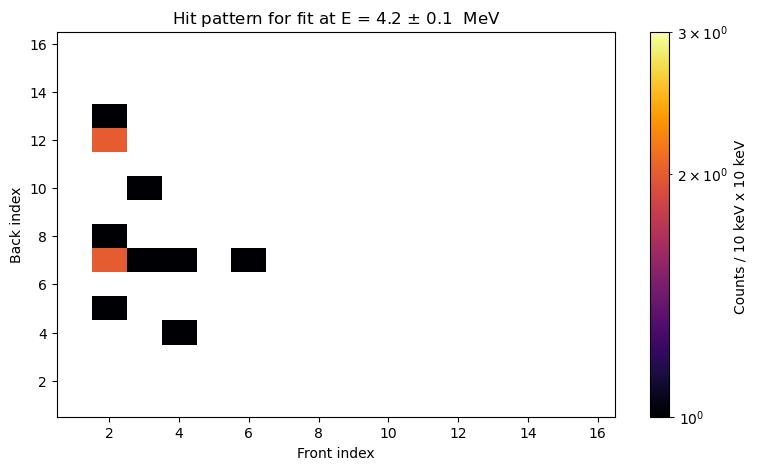

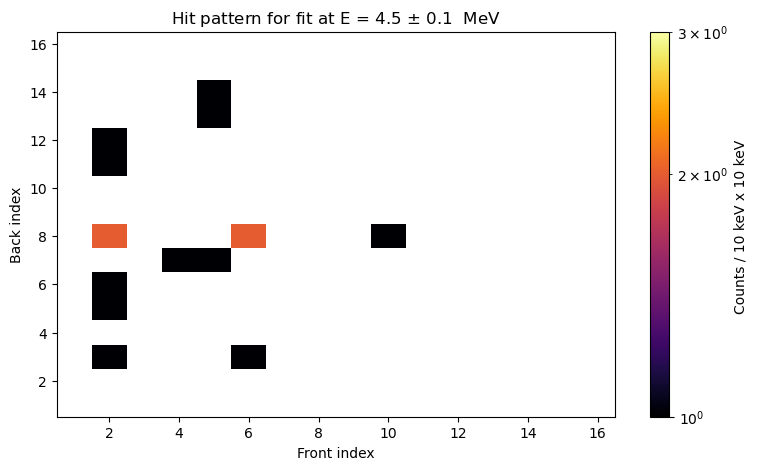

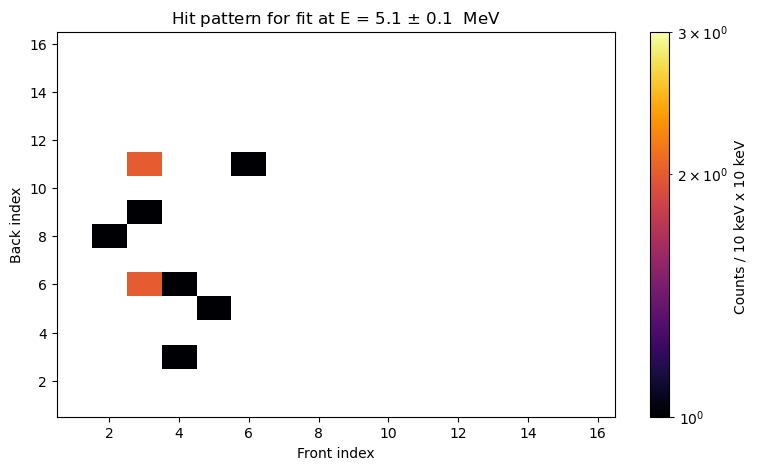

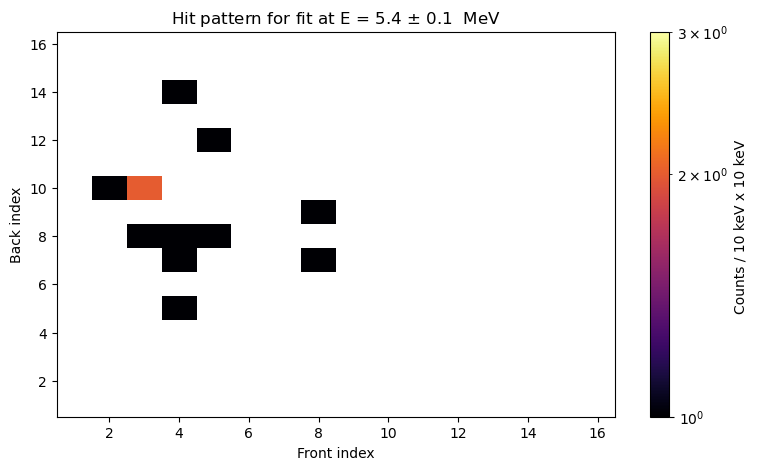

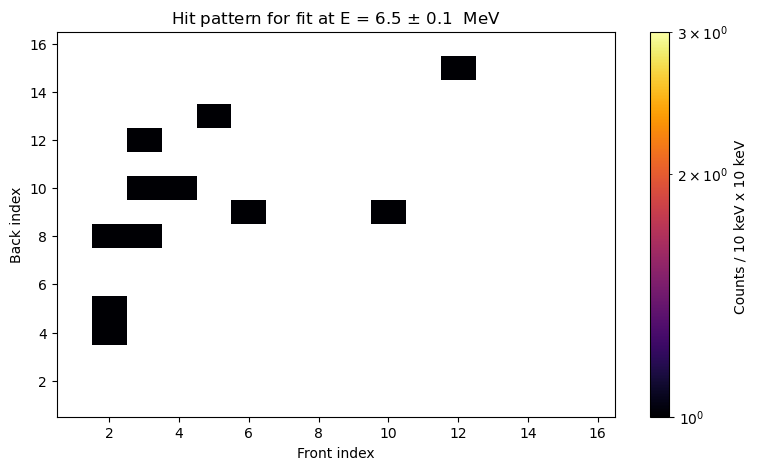

In [22]:
### Hit patterns from the events used to make the linear fits on U1
intervals_of_interest = [(3.9, 4.1), (4.1,4.31), (4.4,4.61), (5, 5.2), (5.3, 5.5), (6.4, 6.61)]
fs = bs = []
for i in intervals_of_interest:
    mask = (es>=i[0]) & (es<=i[1])
    ef_int = ef[mask]
    eb_int = eb[mask]
    fi_int = fi[mask]
    bi_int = bi[mask]
    plt.figure(figsize=(9,5))
    plt.hist2d(fi_int-0.5, bi_int-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
    plt.title(f"Hit pattern for fit at E = {np.round((i[0]+i[1])/2, 1)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')

Amount of counts in hit pattern 488
How many counts in each strip for front side: 
Counter({6: 79, 3: 78, 11: 75, 8: 51, 7: 46, 2: 38, 12: 37, 10: 31, 5: 23, 13: 11, 15: 9, 4: 6, 9: 4})

How many counts in each strip for back side: 
Counter({7: 78, 8: 76, 6: 62, 9: 53, 5: 44, 2: 43, 13: 40, 3: 34, 10: 17, 4: 11, 11: 10, 14: 10, 15: 5, 12: 5})


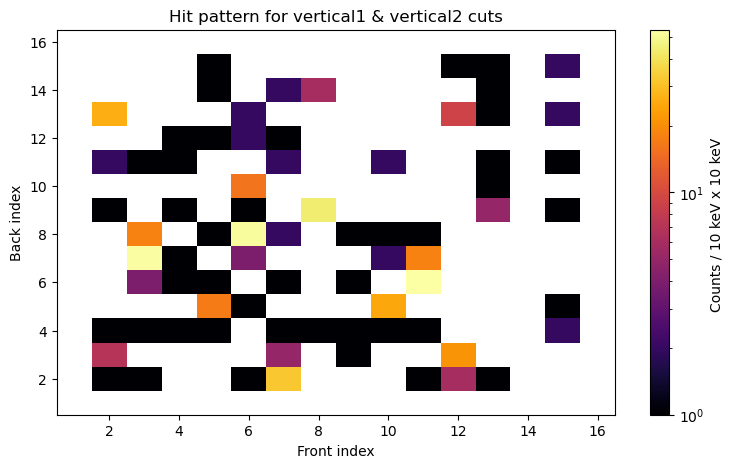

In [ ]:
##################
## Now i want to look at the two vertical regions that are given by x2y2 and x3y3.
## I want to investigate the hitpatterns for these events
## Again i start of by specifying the events needs to lie within either zone.
##################

poly1 = np.column_stack((xs[1], ys[1]))
poly2 = np.column_stack((xs[2], ys[2]))
poly1_path = Path(poly1)
poly2_path = Path(poly2)
points = np.column_stack((back_telescope_Es[0], front_telescope_Es[0]))
mask1 = poly1_path.contains_points(points)
mask2 = poly2_path.contains_points(points)
mask = mask1 | mask2
eB = back_telescope_Es[0][mask]
eF = front_telescope_Es[0][mask]
eS = Es[0][mask]
fiS = FIs[0][mask]
biS = BIs[0][mask]
plt.figure(figsize=(9,5))
plt.hist2d(fiS-0.5, biS-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for vertical1 & vertical2 cuts")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')
print("Amount of counts in hit pattern",len(eS))
print("How many counts in each strip for front side: ")
print(Counter(fiS))
print()
print("How many counts in each strip for back side: ")
print(Counter(biS))
